**Importation of the important librairies**

In [1]:
import torch
import os
import glob
import librosa
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms


# **Data preprocessing**

### **Accessing the .flac audio files and converting them to .npy**

In [4]:

import os
import librosa
import pandas as pd
import numpy as np

def load_audio(file_path, target_sampling_rate=16000):
    audio, sr = librosa.load(file_path, sr=target_sampling_rate)
    return audio, sr

def extract_mfcc(audio, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

os.makedirs('/kaggle/working/Librispeech/MFCCFiles',exist_ok=True)
# Replace 'your_dataset_directory' with the path to the LibriSpeech dataset
dataset_directory = '/kaggle/input/librispeech-500-hours/LibriSpeech/train-other-500'
for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        if filename.endswith('.flac'):
                # print(audio_file_name, "hii3")

                # Load and process audio
                audio, sr = load_audio(os.path.join(dirname, filename))
                mfccs = extract_mfcc(audio, sr)

                np.save(f'/kaggle/working/Librispeech/MFCCFiles/{filename}_mfcc.npy', mfccs)


KeyboardInterrupt: 

### **Transforming the dataset using dataloader**

In [7]:
# Custom dataset class to load MFCC data from .npy files
class MFCCDataset(Dataset):
    def __init__(self, dataset_directory, max_seq_len):
        self.data = []
        self.max_seq_len = max_seq_len
        
        # Loop through speaker directories
        for dirname, _, filenames in os.walk(dataset_directory):
            for filename in filenames:
                if filename.endswith('.npy'):
                    # Load MFCC data from the .npy file
                    mfcc_data = np.load(os.path.join(dirname, filename))
                    # Pad the MFCC sequence to a fixed length
                    mfcc_data = self.pad_sequence(mfcc_data, max_seq_len)
                    self.data.append(mfcc_data)

        # Convert the list to a tensor after all data is collected
        self.data = torch.tensor(self.data).float()

    def pad_sequence(self, sequence, max_seq_len):
        # Pad or truncate the sequence to max_seq_len
        if len(sequence[0]) < max_seq_len:
            sequence = np.pad(sequence, ((0, 0), (0, max_seq_len - len(sequence[0]))), mode='constant')
        elif len(sequence[0]) > max_seq_len:
            sequence = sequence[:, :max_seq_len]
        return sequence

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Set the path to the directory containing the .npy files
npy_directory = '/kaggle/working/Librispeech/MFCCFiles'

# Set the maximum sequence length for padding
max_seq_len = 176

# Load the dataset
dataset = MFCCDataset(npy_directory, max_seq_len)

# **Auto Encoder Model**

In [8]:

# Autoencoder model definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [9]:
# Define hyperparameters
input_dim = 13  # Number of MFCC coefficients
latent_dim = 8
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# Initialize autoencoder model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim, latent_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


### **Saving the .npy files generated by decoder and the latent space also.**

In [10]:
import soundfile as sf
# Directory to save generated samples
sample_dir = '/kaggle/working/Librispeech/AE_generated_samples'
sample_dir1='/kaggle/working/Librispeech/LatentSpaceFile'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(sample_dir1, exist_ok=True)

# List to store latent space representations
latent_space_representations = []

losses = []
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize loss for the current epoch
    for mfcc_batch in dataset:
        mfcc_batch = mfcc_batch.to(device)

        # Reshape MFCC batch to match the input dimension
        mfcc_batch = mfcc_batch.view(-1, input_dim)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(mfcc_batch)

        # Compute loss and backpropagation
        loss = criterion(outputs, mfcc_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(dataset)

    # Append the average loss to the list for plotting
    losses.append(avg_epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Generate and save samples
    with torch.no_grad():
        sample_noise = torch.randn(5, latent_dim).to(device)
        generated_samples = model.decoder(sample_noise)

        #extracting latent space
        encoded_samples = model.encoder(mfcc_batch)
        latent_space_representations.append(encoded_samples.detach().cpu().numpy())

        # Reshape generated samples back to MFCC format
        generated_samples = generated_samples.view(-1, input_dim)

        # Save generated samples as .npy files
        for i, sample in enumerate(generated_samples):
            sample_file = os.path.join(sample_dir, f'epoch_{epoch+1}_sample_{i}.npy')
            np.save(sample_file, sample.cpu().numpy())


# Convert the list of latent space representations to a numpy array
latent_space_representations = np.concatenate(latent_space_representations, axis=0)

# Save latent space representations as a numpy array
latent_space_file = os.path.join(sample_dir1, 'latent_space.npy')
np.save(latent_space_file, latent_space_representations)

os.makedirs('/kaggle/working/Librispeech/Model',exist_ok=True)
# Save trained autoencoder model
torch.save(model.state_dict(), '/kaggle/working/Librispeech/Model/autoencoder_model.pth')

Epoch [1/20], Loss: 7257.5522
Epoch [2/20], Loss: 7257.3501
Epoch [3/20], Loss: 7257.2520
Epoch [4/20], Loss: 7257.1782
Epoch [5/20], Loss: 7257.1709
Epoch [6/20], Loss: 7257.1621
Epoch [7/20], Loss: 7257.1382
Epoch [8/20], Loss: 7257.1704
Epoch [9/20], Loss: 7257.1313
Epoch [10/20], Loss: 7257.1753
Epoch [11/20], Loss: 7257.1553
Epoch [12/20], Loss: 7257.1577
Epoch [13/20], Loss: 7257.1445
Epoch [14/20], Loss: 7257.1460
Epoch [15/20], Loss: 7257.1631
Epoch [16/20], Loss: 7257.1426
Epoch [17/20], Loss: 7257.1465
Epoch [18/20], Loss: 7257.1494
Epoch [19/20], Loss: 7257.1729
Epoch [20/20], Loss: 7257.1240


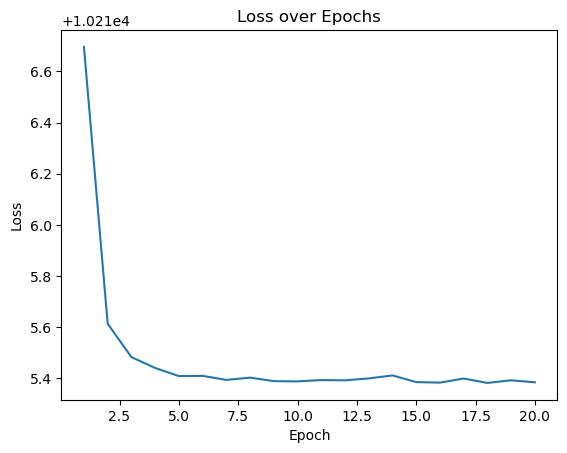

In [11]:
import matplotlib.pyplot as plt
# Plotting the loss function
plt.plot(np.arange(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

# **Now Our Final GAN Model Will start.**

## **This File is for the latent space to train with generator and produce new samples, and discriminator with the Decoders output to descriminate with the generators output.**

### **Loading the Mfcc data which was created by the AE Model.**

In [12]:
# Custom dataset class to load MFCC data from .npy files
class MFCCDataset(Dataset):
    def __init__(self, dataset_directory, max_seq_len):
        self.data = []
        self.max_seq_len = max_seq_len

        for audio_file_name in os.listdir(dataset_directory):
          if audio_file_name.endswith('.npy'):
            # Load MFCC data from the .npy file
            mfcc_data = np.load(os.path.join(dataset_directory, audio_file_name))
            self.data.append(mfcc_data)

        # Convert the list to a tensor after all data is collected
        self.data = torch.tensor(self.data).float()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Set the path to the directory containing the .npy files generated by Autoencoder Model
npy_directory = '/kaggle/working/Librispeech/AE_generated_samples'

# Set the maximum sequence length for padding
max_seq_len = 176

# Load the dataset
dataset = MFCCDataset(npy_directory, max_seq_len)

# **Loading the latent space data**

In [13]:
#load the latent space file.
latent_space_file = '/kaggle/working/Librispeech/LatentSpaceFile/latent_space.npy'
latent_space_representations = np.load(latent_space_file)

# **The Generator and the Discriminator module**

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # Tanh activation to ensure generated values are within [-1, 1]
        )

    def forward(self, x):
        return self.model(x)



class Discriminator(nn.Module):
    # Define your discriminator architecture here
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        # Define the discriminator architecture using nn.Sequential
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),        # Input layer: input_dim -> 512 units
            nn.ReLU(True),                    # ReLU activation
            nn.Linear(512, 256),              # Hidden layer: 512 units -> 256 units
            nn.ReLU(True),                    # ReLU activation
            nn.Linear(256, 1),                # Output layer: 256 units -> 1 unit (binary classification)
            nn.Sigmoid()                      # Sigmoid activation for binary classification
        )

    def forward(self, x):
        # Implement the forward pass for the discriminator
        return self.model(x)


# **The Training loop and saving loop for saving the fresh data created by Gan(the final output)**

In [15]:
import soundfile as sf

def compute_generator_loss(generated_data, real_data):
    # Compute Mean Squared Error (MSE) loss between generated and real data
    mse_loss = nn.MSELoss()
    loss = mse_loss(generated_data, real_data)
    return loss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create DataLoaderdat
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Initialize the generator
# Define hyperparameters
latent_dim = 8  # Dimensionality of the latent space
output_dim = 13
generator = Generator(latent_dim, output_dim)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Initialize discriminator
discriminator = Discriminator(input_dim=13)  # Use the appropriate input dimension
# Define optimizer for the discriminator
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
num_epochs=20
batch_size=64

os.makedirs('kaggle/working/Librispeech/GAN_generated_samples',exist_ok=True)
discriminator_losses = []
generator_losses = []

# Training loop
for epoch in range(num_epochs):
    for real_mfcc_batch in dataloader:  # Your real data loader
        real_mfcc_batch = real_mfcc_batch.to(device)



        # Zero the discriminator parameter gradients
        discriminator_optimizer.zero_grad()

        # Train the discriminator with real data
        real_labels = torch.ones(real_mfcc_batch.size(0), 1).to(device)  # Labels for real data
        real_outputs = discriminator(real_mfcc_batch)

        # Calculate the binary cross-entropy loss
        real_labels_expanded = real_labels.expand_as(real_outputs)  # Expand the labels to match the shape of real_outputs
        real_loss = criterion(real_outputs, real_labels_expanded)
        real_loss.backward()

        # Generate fake data using the generator (decoder)
        # Randomly sample latent space representations
        batch_indices = np.random.randint(len(latent_space_representations), size=batch_size)
        batch_latent_space = latent_space_representations[batch_indices]

        batch_latent_space = torch.randn(real_mfcc_batch.size(0), latent_dim).to(device)  # Match batch size
        generated_data = generator(batch_latent_space)

        # Reshape the generated data to match the shape of real MFCC batch
        generated_data = generated_data.view(-1, output_dim)  # Match the appropriate dimension


        # Update the generator using a loss that encourages the generated data to match the real data distribution in the latent space
        generator_optimizer.zero_grad()
        generator_loss = compute_generator_loss(generated_data, real_mfcc_batch)
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator with generated data
        fake_labels = torch.zeros(generated_data.size(0), 1).to(device)  # Labels for fake data
        fake_outputs = discriminator(generated_data.detach())  # Detach to prevent gradients from propagating to the generator
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()

        # Update discriminator parameters
        discriminator_optimizer.step()
        # Append losses to their respective lists
        discriminator_losses.append(real_loss.item() + fake_loss.item())
        generator_losses.append(generator_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Real Loss: {real_loss.item():.4f}, Discriminator Fake Loss: {fake_loss.item():.4f}')
    generator.eval()
    with torch.no_grad():
        for i in range(10):
            # Generate a random noise vector
            noise = torch.randn(1, latent_dim).to(device)

            # Generate fake data using the Generator
            fake_mfcc = generator(noise).squeeze().cpu().numpy()

            # Calculate the number of frames based on the MFCC shape
            n_frames = fake_mfcc.shape[0] // 13  # Assuming each frame has 13 coefficients

            # Reshape the fake MFCCs to the correct shape
            fake_mfcc = fake_mfcc.reshape(13, n_frames)

            # Convert MFCCs back to audio
            fake_audio = librosa.feature.inverse.mfcc_to_audio(fake_mfcc.T)

            # Save the generated audio sample
            generated_sample_path = os.path.join("/kaggle/working/Librispeech/GAN_generated_samples", f'/generated_sample_epoch_{epoch+1}_{i+1}.wav')
            sf.write(generated_sample_path, fake_audio, 16000)
            print(f'Saved generated sample: {generated_sample_path}')

    generator.train()

Epoch [1/20], Discriminator Real Loss: 0.6864, Discriminator Fake Loss: 0.6775
Saved generated sample: /generated_sample_epoch_1_1.wav
Saved generated sample: /generated_sample_epoch_1_2.wav
Saved generated sample: /generated_sample_epoch_1_3.wav
Saved generated sample: /generated_sample_epoch_1_4.wav
Saved generated sample: /generated_sample_epoch_1_5.wav
Saved generated sample: /generated_sample_epoch_1_6.wav
Saved generated sample: /generated_sample_epoch_1_7.wav
Saved generated sample: /generated_sample_epoch_1_8.wav
Saved generated sample: /generated_sample_epoch_1_9.wav
Saved generated sample: /generated_sample_epoch_1_10.wav
Epoch [2/20], Discriminator Real Loss: 0.6415, Discriminator Fake Loss: 0.6724
Saved generated sample: /generated_sample_epoch_2_1.wav
Saved generated sample: /generated_sample_epoch_2_2.wav
Saved generated sample: /generated_sample_epoch_2_3.wav
Saved generated sample: /generated_sample_epoch_2_4.wav
Saved generated sample: /generated_sample_epoch_2_5.wav
S

# **Visualization of the Loss functions of Discriminator and Generator**

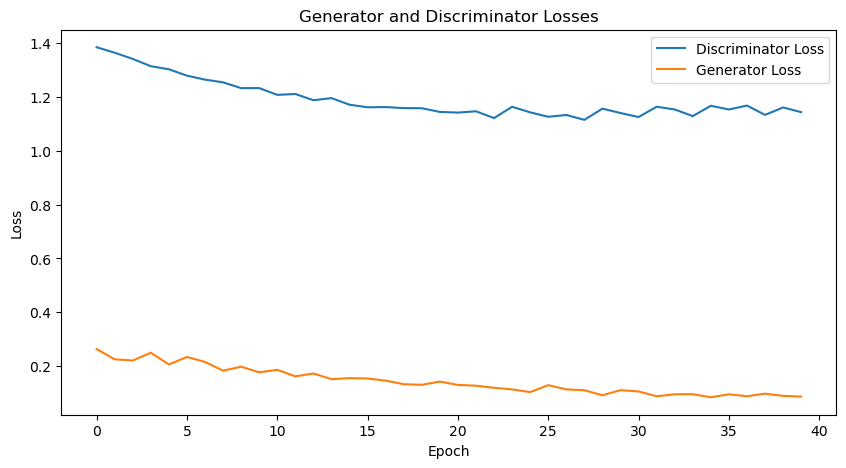

In [16]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.show()